### simple simulation - no transaction fee, no etf expenses, no taxes, no dividends

# 초기 조건 / 데이터 임포트 / 벤치마크 계산

## 라이브러리 임포트 / 초기 조건 설정

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import pandas as pd
import numpy as np
from datetime import datetime

In [25]:
risk_free_rate = 0
transaction_fee = 0
etf_expenses = 0
tax_rate = 0
initial_cash = 10000

In [26]:
current_date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

In [27]:
strategies = []

## 데이터 임포트

In [28]:
df = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/SPY.csv')
closes = df.Close.to_numpy()
result_df = pd.DataFrame({'Date': df['Date']})

## 벤치마크 계산

In [29]:
benchmark_shares = initial_cash // closes[0]
benchmark = closes * benchmark_shares

# [전략1] 단일 12개월 look_back, 1개월 리밸런싱

## 계좌 정보 초기화

In [30]:
name = 'SPY_simulation_12'
df_12 = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/SPY.csv')

In [31]:
cash, account = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(2)]
upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]

In [32]:
rebalancing_period = 1
look_backs = [12]

## 단일 look_back == 12

In [33]:
# look_backs 배열 도입 전 코드
# for i in range(12, len(closes)):
#   if (closes[i] - closes[i-12] >= risk_free_rate):
#     upwards[i] = True
#     if upwards[i-1]:
#       cash[i] = cash[i-1]
#       shares[i] = shares[i-1]
#       positions[i] = shares[i] * closes[i]
#     else:
#       shares[i] = cash[i-1] // closes[i]
#       positions[i] = shares[i] * closes[i]
#       cash[i] = cash[i-1] - positions[i]
#     account[i] = cash[i] + positions[i]
#   else:
#     upwards[i] = False
#     shares[i] = 0
#     positions[i] = 0
#     if upwards[i-1]:
#       cash[i] = cash[i-1] + shares[i-1] * closes[i]
#     else:
#       cash[i] = cash[i-1]
#     account[i] = cash[i] + positions[i] 
#   changes_12[i] = (closes[i] - closes[i-12]) / closes[i-12]

In [34]:
for i in range(max(look_backs), len(closes)):
  #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
  # cash[i] = cash[i - 1] dividends[i] * shares[i - 1]
  look_back_upwards = [1 if closes[i] - closes[i-look_back] >= risk_free_rate else 0 for look_back in look_backs]
  upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
  upwards[i] = upwards_ratio
  shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
  shares_delta = shares[i] - shares[i - 1]
  if shares_delta == 0:
    # 보유
    cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
    positions[i] = shares[i] * closes[i]
  else:
    # 추가 매수, 매도 공통
    cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
    positions[i] = closes[i] * shares[i]
    # 거래비용 기록
    if shares_delta < 0:
      # 매도로 인한 손익 기록
      pass
  account[i] = cash[i] + positions[i]

## 계좌 정보 업데이트 / csv로 출력

In [35]:
df_12['Upward'] = upwards.tolist()
df_12['Shares'] = shares.tolist()
df_12['Position'] = positions.tolist()
df_12['Cash'] = cash.tolist()
df_12['Account'] = account.tolist()
df_12['Benchmark'] = benchmark.tolist()

In [36]:
df_12.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')

In [37]:
strategies.append({"name":'12', "df":df_12})

# [전략2] 단일 12개월 look_back, 6개월 리밸런싱

In [38]:
start_lag = 2
rebalancing_period = 6
look_backs = [12]
for index in range(6):
  df = pd.read_csv('/content/drive/MyDrive/quant_projects/momentum_strategies/SPY.csv')
  simulation_detail = f'{index + start_lag}to{index + start_lag + rebalancing_period}'
  name = f'SPY_simulation_6:12_{simulation_detail}'
  cash, account = [np.array([initial_cash] * len(closes), dtype=np.float64) for _ in range(2)]
  upwards, positions, shares = [np.zeros(len(closes)) for _ in range(3)]
  for i in range(max(look_backs), len(closes)):
    #조건에 만족하면 배당수익 기록 (보유 현금 증가로)
    # cash[i] = cash[i - rebalancing_period] dividends[i] * shares[i - rebalancing_period]
    if i % rebalancing_period == index:
      look_back_upwards = [1 if closes[i] - closes[i-look_back] >= risk_free_rate else 0 for look_back in look_backs]
      upwards_ratio = sum(look_back_upwards) / len(look_back_upwards)
      upwards[i] = upwards_ratio
      shares[i] = (shares[i - 1] * closes[i] + cash[i - 1]) * upwards[i] // closes[i]
      shares_delta = shares[i] - shares[i - 1]
      if shares_delta == 0:
        # 보유
        cash[i] = cash[i - 1] #만약 지난달에 배당을 받았다면 주식:현금 비율이 변화하므로 리밸런싱 필요
        positions[i] = shares[i] * closes[i]
      else:
        # 추가 매수, 매도 공통
        cash[i] = cash[i - 1] - (shares_delta) * closes[i] #shares_delta가 양수면 매수, 음수면 매도
        positions[i] = closes[i] * shares[i]
        # 거래비용 기록
        if shares_delta < 0:
          # 매도로 인한 손익 기록
          pass
    else:
      cash[i] = cash[i-1]
      shares[i] = shares[i-1]
      positions[i] = shares[i] * closes[i]
    account[i] = cash[i] + positions[i]
  df['Upward'] = upwards.tolist()
  df['Shares'] = shares.tolist()
  df['Position'] = positions.tolist()
  df['Cash'] = cash.tolist()
  df['Account'] = account.tolist()
  df['Benchmark'] = benchmark.tolist()
  df.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{name}.csv')
  strategies.append({"name":simulation_detail, "df":df})

# 결과 출력

## csv / jpg 출력

In [39]:
result_df['Benchmark'] = benchmark.tolist()

In [40]:
for strategy in strategies:
  result_df[strategy['name']] = strategy['df']['Account'].tolist()

In [41]:
result_df.head()

,Date,Benchmark,12,2to8,3to9,4to10,5to11,6to12,7to13
0,1993-02-01,9991.40625,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
1,1993-03-01,10167.18750,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
2,1993-04-01,9907.03125,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
3,1993-05-01,10174.21875,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
4,1993-06-01,10139.06250,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0


In [42]:
result_df.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_result.csv')

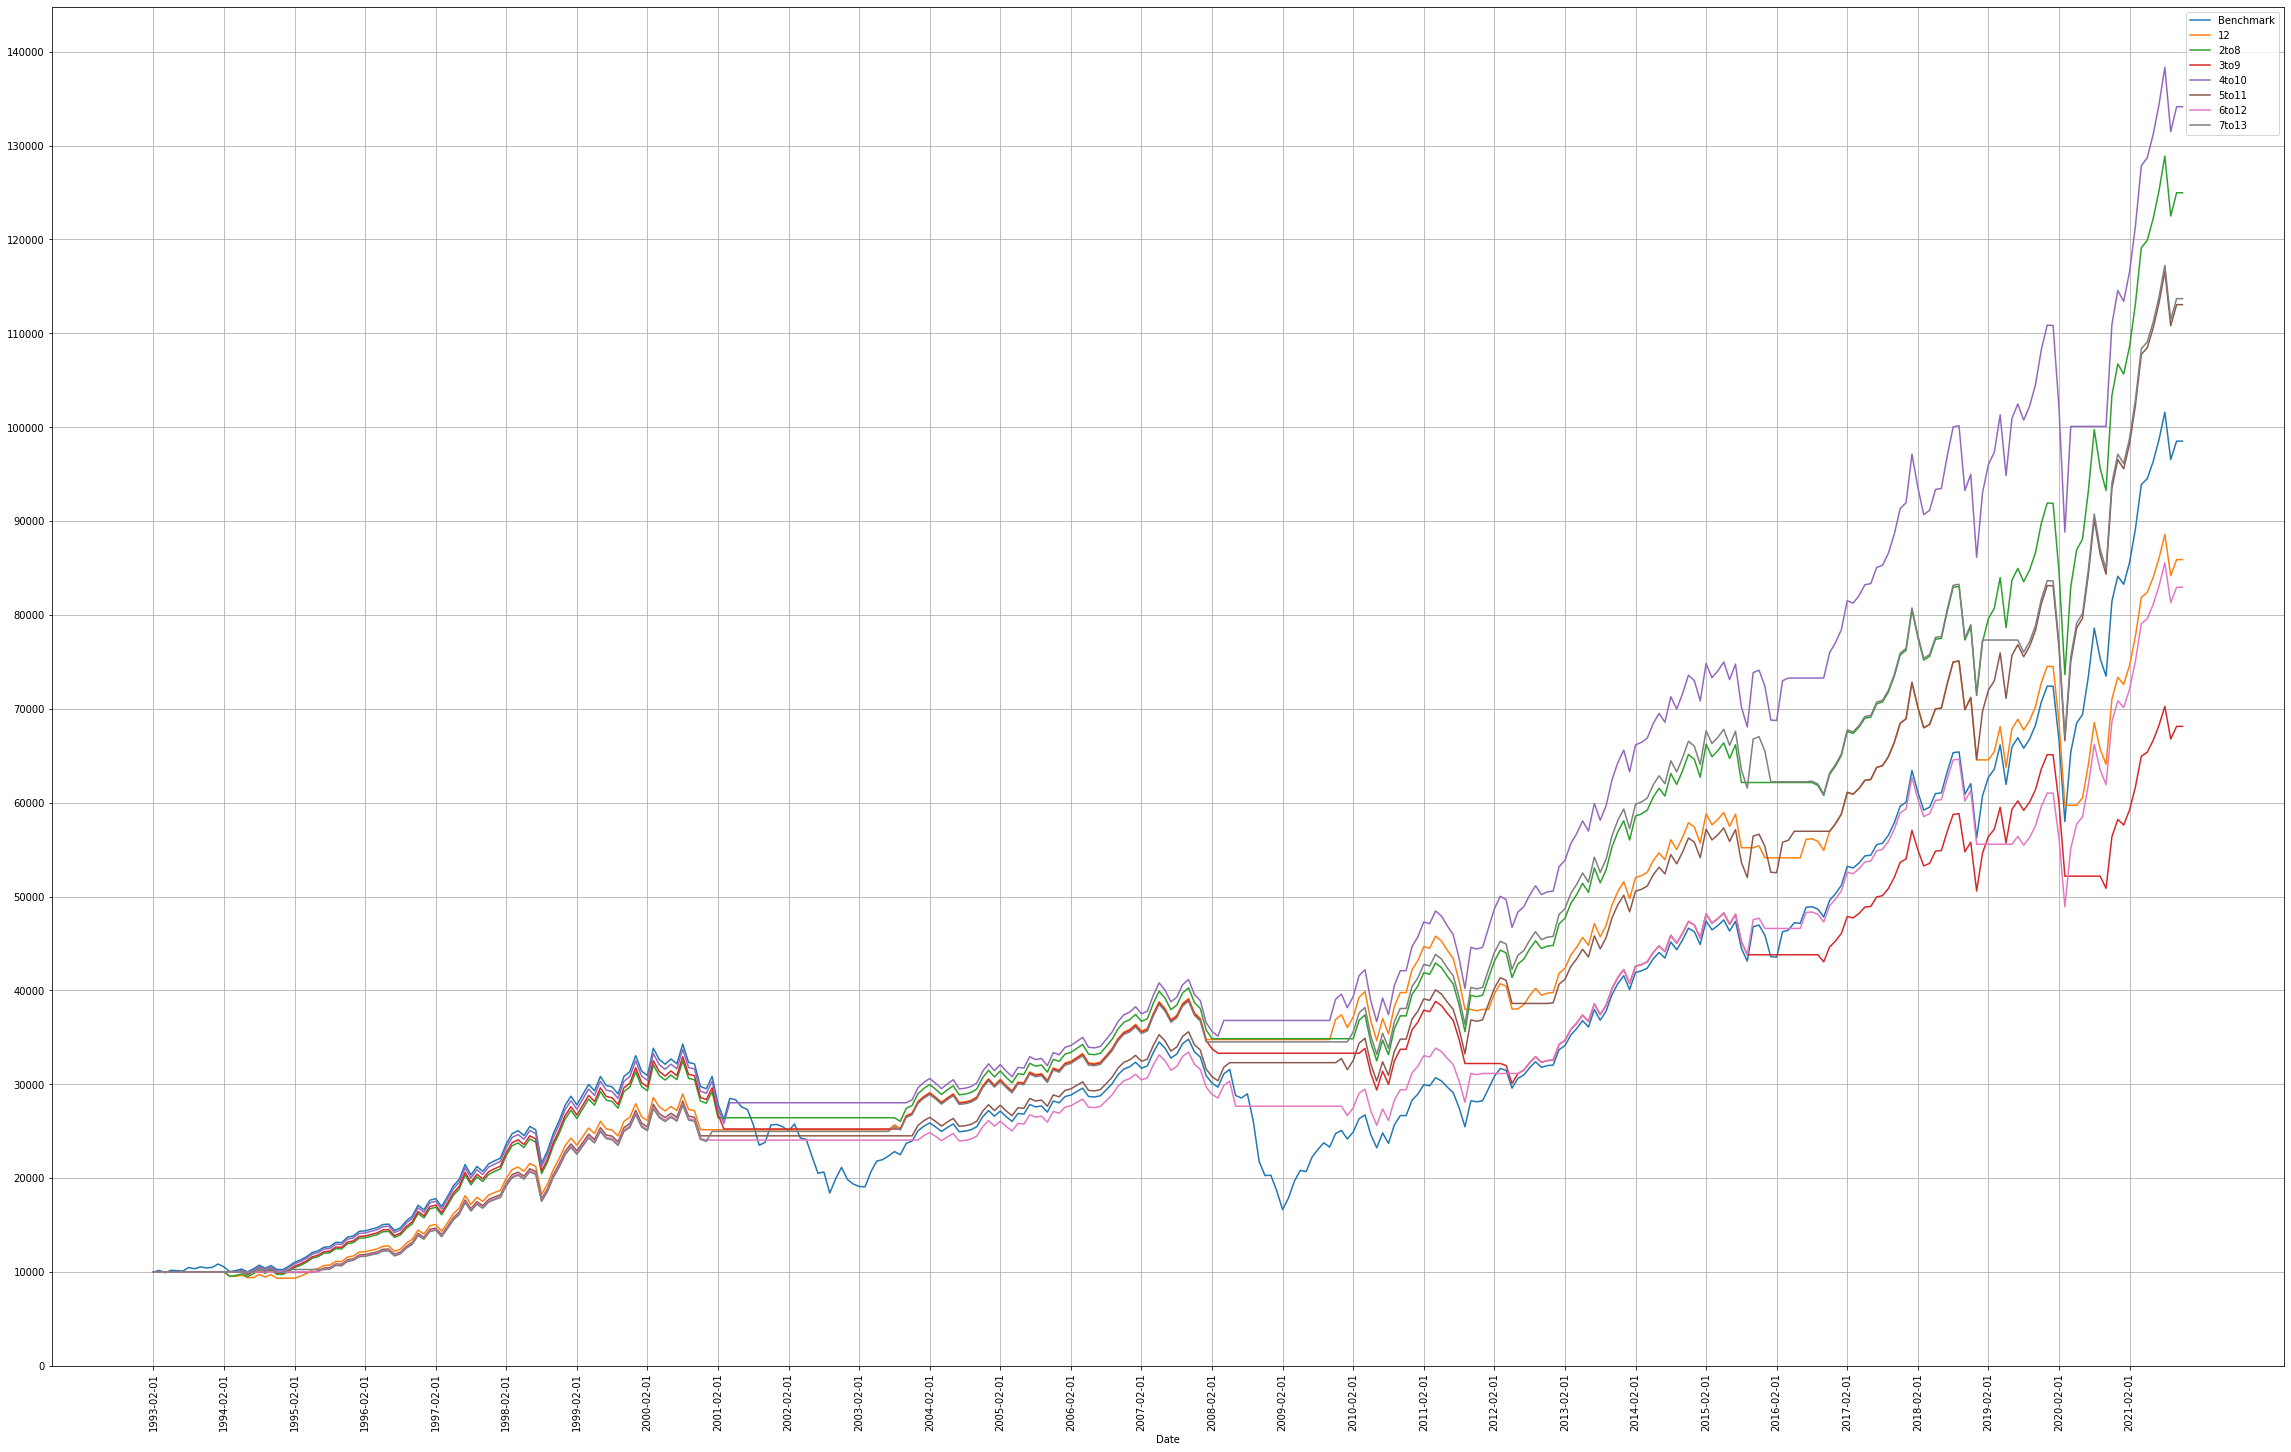

In [43]:
chart = result_df.plot.line(x='Date', grid=True, figsize=(40,25), xticks=np.arange(0, 346, 12), yticks=np.arange(0, 150000, 10000))
chart.tick_params(axis='x', rotation=90)
chart.figure.savefig(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_result.jpg')